# Churn Prediction using Random Forest Classifier
We apply Random Forest ensemble to the customer data for churn prediction. The results are comparable to those 
achieved by the ANN churn prediction model. 

The major steps taken to improve accuracy, precision and recall are:
- Stratification based on EDA done in the accompanying ANN churn prediction N/B. 
- Determining feature rank based on initial tree fitment.
- Tuning the hyperparameters of the Random Forest Classifier.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
import pandas as pd

In [3]:
churndf = pd.read_csv("./Data/Churn_Modelling.csv")
churndf #Preliminary view of dataframe

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
#Separate into data and target
X = churndf.iloc[:,3:-1] #Skip the first three metadata columns and the last target column
y = churndf.iloc[:,-1:]
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [5]:
#Split our data into training and test set 
#We stratify based on EDA of the data. See accompanying churn_ann notebook.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=1,stratify=X[['Geography','NumOfProducts','Gender']])
X_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
5184,728,France,Female,28,4,142243.54,2,1,0,33074.51
6500,582,France,Female,43,5,153313.67,1,0,0,170563.73
6543,814,Germany,Male,29,1,131968.57,2,1,1,147693.92
9420,657,France,Female,28,7,0.00,2,0,1,5177.62
8146,717,France,Male,48,7,123764.95,1,1,1,169952.82
...,...,...,...,...,...,...,...,...,...,...
1983,748,Spain,Female,40,4,0.00,2,1,0,132368.47
2647,461,France,Male,51,9,119889.84,1,0,0,56767.67
3987,633,France,Male,37,7,141546.35,1,1,1,124830.11
826,680,France,Female,47,5,0.00,2,1,1,179843.33


In [6]:
# sklearn classifier converts all features to float. Hence we have no option but 
# to convert the two text fields Geography and Gender to an ordinal or OneHot encoding. 
# Both encodings seem to give similar accuracy/precision-recall scores 

from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as prep
colxformer = ColumnTransformer([
    ('ordenc',prep.OrdinalEncoder(),['Geography','Gender'])
    ],
    remainder='passthrough')

#Fit the training data into the transformer
colxformer.fit(X_train)
#And transform both the training and test data sets
X_train_es = pd.DataFrame(colxformer.transform(X_train))
X_test_es = pd.DataFrame(colxformer.transform(X_test))
#y_test and y_train are already binary encoded and don't need transformation.

#Restore the column names for purpose of knowing feature importance
#Rearrange the order because col-x-former moves xformed cols to the left
# No one-hot encoding; hence number of cols remains the same.
orig_col_names = list(X_test)
X_train_es.columns = orig_col_names[1:3]+orig_col_names[:1]+orig_col_names[3:]
X_test_es.columns = orig_col_names[1:3]+orig_col_names[:1]+orig_col_names[3:]


In [13]:
# Importing random forest classifier from ensemble module
from sklearn.ensemble import RandomForestClassifier

#creating a RF classifier 100 subtrees do not split nodes < 30 datapoints
clf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 30)

#Training the model on the training dataset
#Fit function is used to train the model using the training set
clf.fit(X_train_es,y_train.values.ravel())


RandomForestClassifier(min_samples_split=30)

## Estimate the important features
... and drop the unimportant ones.  Having created/fitted a classifier, we can get the relative
importance of features. The less important once can be removed thus reducing noise.

Age                0.325862
NumOfProducts      0.232872
Balance            0.107411
CreditScore        0.079122
EstimatedSalary    0.078770
IsActiveMember     0.069258
Geography          0.040741
Tenure             0.038985
Gender             0.020131
HasCrCard          0.006849
dtype: float64

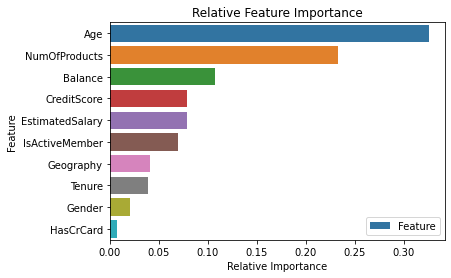

In [8]:
feat_imp = pd.Series(clf.feature_importances_, index=list(X_train_es)).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=feat_imp, y=feat_imp.index, label='Feature')
plt.title('Relative Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.legend()
feat_imp

### Refit the random forest model
From the above bar chart, we pick the first four and re-fit our model with just these four features.

In [14]:
#We select all but the last two features. To observe how specific features impact classifier
#performance remove Age and NumOfProducts from the list below and observe changes in the ROC
#and in the precision-recall curves.
top_feat = ['Age','EstimatedSalary','Balance','CreditScore','NumOfProducts',
            'IsActiveMember','Geography','Tenure']   
X_train_es = X_train_es[top_feat]
X_test_es = X_test_es[top_feat]
clf.fit(X_train_es,y_train.values.ravel())

RandomForestClassifier(min_samples_split=30)

### Prediction and Evaluation


In [15]:
#Prediction and evalueation

y_pred = (clf.predict(X_test_es))

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_roc_curve

tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()

print("\nConfusion matrix Wikipedia style...")
print("%d %d" %(tp,fn))
print("%d %d" %(fp,tn))
print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred))
print("Precision Score:",precision_score(y_test,y_pred))


Confusion matrix Wikipedia style...
291 356
78 2575
Accuracy Score: 0.8684848484848485
Recall Score: 0.44976816074188564
Precision Score: 0.7886178861788617


## ROC Curve

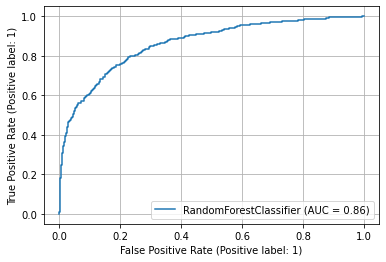

In [16]:
import matplotlib.pyplot as plt
plot_roc_curve(clf, X_test_es, y_test)
plt.grid()
plt.show()

## Precision Recall Curve

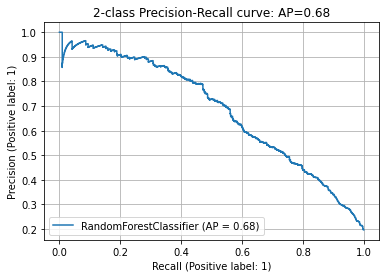

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import plot_precision_recall_curve

y_score = clf.predict_proba(X_test_es)
average_precision = average_precision_score(y_test, y_score[:,1])

disp = plot_precision_recall_curve(clf, X_test_es, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision))
plt.grid()

#### End of Notebook